# Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2 as cv

# Data Loading

In [ ]:
# Download the data stored in a zipped numpy array from one of these two locations
# The uncommented one is likely to be faster. If you're running all your experiments
# on a machine at home rather than using colab, then make sure you save it 
# rather than repeatedly downloading it.

#!wget "http://users.sussex.ac.uk/~is321/training_images.npz" -O training_images.npz
!wget "https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz" -O training_images.npz

# The test images (without points)
#!wget "http://users.sussex.ac.uk/~is321/test_images.npz" -O test_images.npz
!wget "https://sussex.box.com/shared/static/xxlgvjpa86s6xgjzy5im06saoj57s7gt.npz" -O test_images.npz

# The example images are here
#!wget "http://users.sussex.ac.uk/~is321/examples.npz" -O examples.npz
!wget "https://sussex.box.com/shared/static/kbodelmaqw5dd59i5x2kis55lor7ydhf.npz" -O examples.npz



--2022-05-10 16:11:21--  https://sussex.box.com/shared/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Resolving sussex.box.com (sussex.box.com)... 103.116.4.197
Connecting to sussex.box.com (sussex.box.com)|103.116.4.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz [following]
--2022-05-10 16:11:21--  https://sussex.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Reusing existing connection to sussex.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://sussex.app.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz [following]
--2022-05-10 16:11:21--  https://sussex.app.box.com/public/static/jqrklxpl2c5hnrkpa2m7f9da2o3np8g9.npz
Resolving sussex.app.box.com (sussex.app.box.com)... 185.235.236.201
Connecting to sussex.app.box.com (sussex.app.box.com)|185.235.236.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Loca

# Check the data downloaded correctly
If any of these assertions fail, redownload the data

In [ ]:
def confirm_checksum(filename, true_checksum):
  import subprocess
  checksum = subprocess.check_output(['shasum',filename]).decode('utf-8')
  assert checksum.split(' ')[0] == true_checksum, 'Checksum does not match for ' + filename + ' redownload the data.'

confirm_checksum('training_images.npz', 'f313a54fc57a1235e6307d176fc5fc83fd7ec530')
confirm_checksum('test_images.npz', '4b9efd8eb3b87c07d9c5400ef2494d476bc318a3')
confirm_checksum('examples.npz', 'bf51ebbf42f17e3cbe06bb299746565c53d16c40')

# Load the data

In [ ]:
import numpy as np


# Load the data using np.load
data = np.load('training_images.npz', allow_pickle=True)

# Extract the images
images = data['images']
# and the data points
pts = data['points']

print(images.shape, pts.shape)

test_data = np.load('test_images.npz', allow_pickle=True)
test_images = test_data['images']
print(test_images.shape)

example_data = np.load('examples.npz', allow_pickle=True)
example_images = example_data['images']
print(example_images.shape)

(2811, 244, 244, 3) (2811, 42, 2)
(554, 244, 244, 3)
(6, 244, 244, 3)


# Data Preprocessing

In [ ]:
images.shape[1]

244

In [ ]:
## Lower resolution (should make everything more efficient and limit the size
## of the data going into the CNN)

def cut_res(imgs, scale): 
  ## Array for "new" images

  low_res_imgs = []


  ## Set dimensions for the new images (all of them are square, so we only need
  ## one side)

  side = int(imgs.shape[0] * scale)
  dim = (side, side)

  ## Change resolution of each image
  for img in imgs:
    low_res_imgs.append(cv.resize(img, dim, interpolation = cv.INTER_AREA))
  return (np.array(low_res_imgs))

res_change = 0.5
images_half = cut_res(np.copy(images), res_change)
test_images_half = cut_res(np.copy(test_images), res_change)
example_images_half = cut_res(np.copy(example_images), res_change)

# Data Visualisation
Here's an example of how to display the images and their points

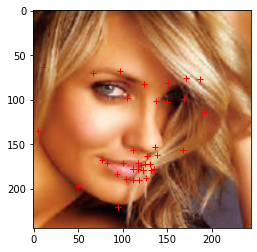

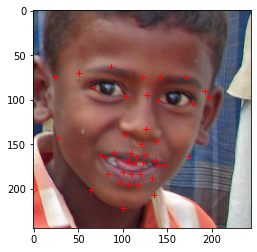

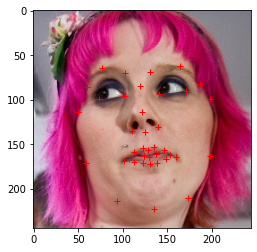

In [ ]:
def visualise_pts(img, pts):
  import matplotlib.pyplot as plt
  plt.imshow(img)
  plt.plot(pts[:, 0], pts[:, 1], '+r')
  plt.show()

for i in range(3):
  idx = np.random.randint(0, images.shape[0])
  visualise_pts(images[idx, ...], pts[idx, ...])

# CNN

In [ ]:
##Imports

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
## Implement early stopping
es = callbacks.EarlyStopping(monitor = "loss", patience = 3)


## CNN with 3 convolutional layers and 2 max pooling layers 
## to condense the output

model = models.Sequential()
model.add(layers.Conv2D(32, (7, 7), activation = "relu", 
                        input_shape = (244, 244, 3)))
model.add(layers.Conv2D(32, (7, 7), activation = "relu"))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(32, (5, 5), activation = "relu"))
model.add(layers.Conv2D(32, (5, 5), activation = "relu"))
model.add(layers.MaxPooling2D((3, 3)))
model.add(layers.Conv2D(32, (3, 3), activation = "relu"))
model.add(layers.Conv2D(32, (3, 3), activation = "relu"))

## Flatten output

model.add(layers.Flatten())
##model.add(layers.Dense(244, activation = "relu"))


## Output

model.add(layers.Dense(84))


## Reshape to 42x2 array (42 (x, y) coordinates)

model.add(layers.Reshape((42, 2)))

In [ ]:
## Split training images into train-test split to limit overfitting and include 
## validation data (provided test set does not include points)

X_train, X_test, y_train, y_test = train_test_split(images, pts, 
                                                    test_size = 0.2, 
                                                    random_state = 99)

In [ ]:
## Model compilation

model.compile(optimizer="adam",
              loss = "mse",
              metrics = ["mse"])


## Model fitting

history = model.fit(X_train, y_train, epochs = 100, 
                    validation_data = (X_test, y_test), callbacks = es)

Epoch 1/100
71/71 [==============================] - 23s 148ms/step - loss: 8390.7363 - mse: 8390.7354 - val_loss: 873.0098 - val_mse: 873.0099
Epoch 2/100
71/71 [==============================] - 9s 125ms/step - loss: 746.8828 - mse: 746.8826 - val_loss: 569.8354 - val_mse: 569.8354
Epoch 3/100
71/71 [==============================] - 9s 125ms/step - loss: 584.9612 - mse: 584.9612 - val_loss: 488.8904 - val_mse: 488.8904
Epoch 4/100
71/71 [==============================] - 9s 125ms/step - loss: 454.8070 - mse: 454.8071 - val_loss: 494.9338 - val_mse: 494.9338
Epoch 5/100
71/71 [==============================] - 9s 126ms/step - loss: 381.6983 - mse: 381.6983 - val_loss: 606.3885 - val_mse: 606.3886
Epoch 6/100
71/71 [==============================] - 9s 126ms/step - loss: 339.8305 - mse: 339.8305 - val_loss: 281.0674 - val_mse: 281.0673
Epoch 7/100
71/71 [==============================] - 9s 126ms/step - loss: 195.6132 - mse: 195.6132 - val_loss: 260.7097 - val_mse: 260.7097
Epoch 8/10

18/18 - 1s - loss: 25.3427 - mse: 25.3427 - 770ms/epoch - 43ms/step


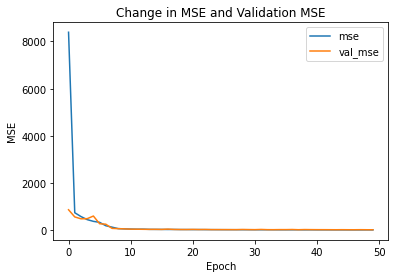

In [ ]:
## Plots

plt.plot(history.history["mse"], label = "mse")
plt.plot(history.history["val_mse"], label = "val_mse")
plt.title("Change in MSE and Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend(loc = "upper right")

test_loss, test_mse = model.evaluate(X_test,  y_test, verbose = 2)

In [ ]:
## Predicting test points

pred_pts = model.predict(images)
test_pts = model.predict(test_images)

In [ ]:
##Gotta make sure that it works

for i in range(50):
  idx = np.random.randint(0, test_images.shape[0])
  visualise_pts(test_images[idx, ...], test_pts[idx, ...])

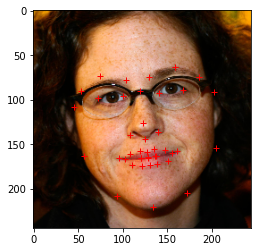

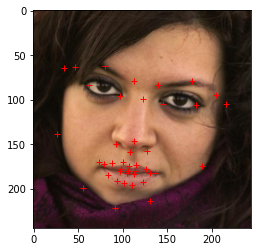

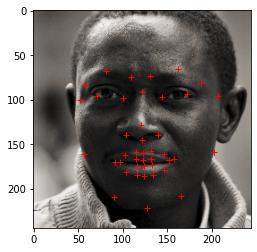

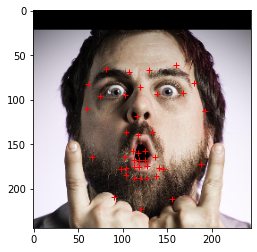

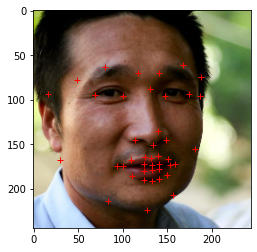

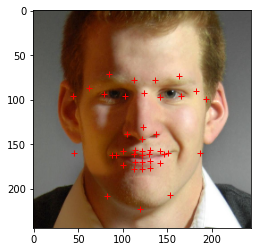

In [ ]:
## Example Images

example_pts = model.predict(example_images)
for i in range(6):
  visualise_pts(example_images[i, ...], example_pts[i, ...])

In [ ]:
## Save the  model (because my god, I got lucky this time)

model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [ ]:
## Run this to load the model back again (just in case my runtime screws up)

new_model = tf.keras.models.load_model('saved_model/my_model')

# Calculating Prediction Error and Graphs

In [ ]:
def euclid_dist(pred_pts, gt_pts):
  """
  Calculate the euclidean distance between pairs of points
  :param pred_pts: The predicted points
  :param gt_pts: The ground truth points
  :return: An array of shape (no_points,) containing the distance of each predicted point from the ground truth
  """
  import numpy as np
  pred_pts = np.reshape(pred_pts, (-1, 2))
  gt_pts = np.reshape(gt_pts, (-1, 2))
  return np.sqrt(np.sum(np.square(pred_pts - gt_pts), axis=-1))


In [ ]:
ed = euclid_dist(pred_pts, pts)

In [ ]:
ed

array([3.20853448, 0.43228764, 2.63386398, ..., 3.37781907, 4.3341765 ,
       5.22634944])

In [ ]:
## Average distance between predicted and ground truth points

np.average(ed)

4.924172903245675

In [ ]:
## Percentage of point distance <= 10

np.where(ed <= 10)[0].size/ed.size

0.9174501533092781

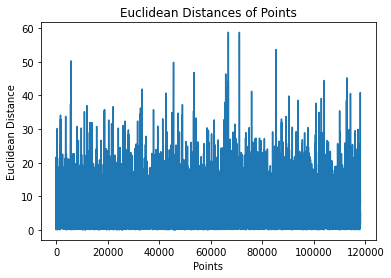

In [ ]:
## Line chart

x = np.arange(0, len(ed))
y = ed
 

## Plotting

plt.plot(x, y)
plt.title("Euclidean Distances of Points")
plt.xlabel("Points")
plt.ylabel("Euclidean Distance")
plt.show()

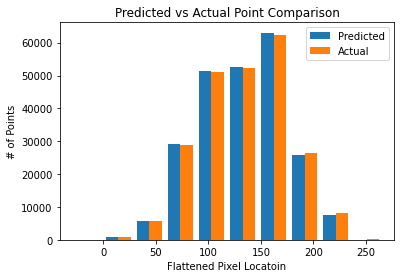

In [ ]:
## Histogram

plt.hist([pred_pts.flatten(), pts.flatten()])
plt.title("Predicted vs Actual Point Comparison")
plt.xlabel("Flattened Pixel Locatoin")
plt.ylabel("# of Points")
plt.legend(["Predicted", "Actual"])
plt.show()

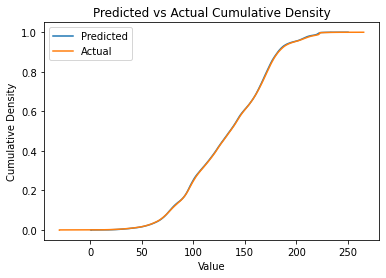

In [ ]:
## Cumulative Density Plot

for points in [pred_pts.flatten(), pts.flatten()]:
  plt.step(np.sort(points), np.linspace(0, 1, len(points)))
plt.title("Predicted vs Actual Cumulative Density")
plt.xlabel("Value")
plt.ylabel("Cumulative Density")
plt.legend(["Predicted", "Actual"])

# Lip/Eye Recoloring

In [ ]:
## Imports

import cv2 as cv

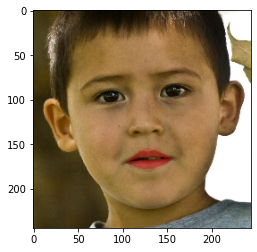

In [ ]:
## Recolor lips and eyes using fillPoly() with predicted landmark points

def lip_recolor(img, pts, color):
  ##Make a copy of the image that includes the overlay of the "lips"

  returned_img = np.copy(img)
  img_overlay = np.copy(img)
  img_overlay = cv.fillPoly(img_overlay, pts = np.int32([pts[22:]]), 
                            color = color)
  

  ##Combine the image and the overlay

  alpha = 0.25
  cv.addWeighted(img_overlay, alpha, returned_img, 1 - alpha, 0, returned_img)
  return (returned_img)

def eye_recolor(img, pts, color):
  left = cv.fillPoly(img, pts = np.int32([pts[18:20]]), color = color)
  left_and_right = cv.fillPoly(left, pts = np.int32([pts[20:22]]), 
                               color = color)
  return (left_and_right)

rouge = lip_recolor(images[2022], pts[2022], (255, 0, 0))
plt.imshow(rouge)
#rouge_et_bleu = eye_recolor(rouge, pts[2022], (0, 0, 255))
#plt.imshow(rouge_et_bleu)

# Exporting Results

In [ ]:
def save_as_csv(points, location = '.'):
    """
    Save the points out as a .csv file
    :param points: numpy array of shape (no_test_images, no_points, 2) to be saved
    :param location: Directory to save results.csv in. Default to current working directory
    """
    assert points.shape[0]==554, 'wrong number of image points, should be 554 test images'
    assert np.prod(points.shape[1:])==2*42, 'wrong number of points provided. There should be 42 points with 2 values (x,y) per point'
    np.savetxt(location + '/results.csv', np.reshape(points, (points.shape[0], -1)), delimiter=',')


In [ ]:
save_as_csv(test_pts)

# Downloading Everything

In [ ]:
from google.colab import files
files.download('saved_model')